In [9]:
from __future__ import print_function
import numpy as np
from scipy import stats, io
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from scipy.signal import detrend as det
%matplotlib inline
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import h5py
#import gsw
#import io
import base64

In [3]:
field = "PHIBOT"
'/home/maike/Documents/ECCO4_rel2/'+field+'/'+field+'.00{:02d}.nc'.format(1)

'/home/maike/Documents/ECCO4_rel2/PHIBOT/PHIBOT.0001.nc'

In [4]:
#We need to glue together the "faces" of ECCOv4
def getFace(faceNr, field):
    #print x, y
    f =Dataset('/home/maike/Documents/ECCO4_rel2/'+field+'/'+field+'.00{:02d}.nc'.format(faceNr))
    ETAN = f.variables[field][:]
    lat = f.variables['lat'][:]
    lon = f.variables['lon'][:]
    land = f.variables['land'][:]
    return ETAN, lat, lon

def rot90Case((sla, lat, lon)):
    sla=np.fliplr(np.transpose(np.fliplr((sla)), [0,2,1]))
    lon=np.flipud(np.rot90(lon,3))
    lat=np.flipud(np.rot90(lat,3))
    return sla, lat, lon

def fliplrCase((sla, lat, lon)):
    sla=np.fliplr(sla)
    lon=np.flipud(lon)
    lat=np.flipud(lat)
    return sla, lat, lon

def addToMatrix(field_collated, lon_collated, lat_collated, x, y, (sla, lat, lon)):
    field_collated[:,90*x:90*(x+1), 90*y:90*(y+1)]=sla
    lon_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lon
    lat_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lat
    return field_collated, lat_collated, lon_collated

In [5]:
def getField(field):
    field_collated=np.zeros([240,90*4,90*3])
    lon_collated=np.zeros([90*4,90*3])
    lat_collated=np.zeros([90*4,90*3])

    x, y, nr = 3, 2, 4
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 1, 5
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 0, 6
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 2, 1
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 1, 2
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 0, 3
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 1, 0, 11
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 1, 12
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 2, 13
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 0, 8
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 1, 9
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 2, 10
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    return field_collated, lat_collated, lon_collated

In [6]:
def makeFig(data, cMin, cMax, cStep, title, ColMap, saveName):
    plt.figure(figsize=(20,12))
    dataPlot=data
    #cMin, cMax, cStep = 0,0.008, 0.0001
    dataIn = sla_collated[2]
    lons = np.roll(np.linspace(0, 360, 360),100)
    lons = lon_collated[:,1]
    dataIn,lons = shiftgrid(lon_collated[0,1],np.flipud(dataIn),lons,start=True, cyclic=360)
    lats = lat_collated[1,:]
    llons, llats = np.meshgrid(lons,lats)
    fig = plt.figure()
    ax = fig.add_axes([0.05,0.05,0.9,0.9])
    # create Basemap instance.
    m = Basemap(projection='kav7',lon_0=130,resolution='l')
    m.drawmapboundary(fill_color='0.9')
    im1 = m.contourf(llons,llats,np.fliplr(np.rot90(dataPlot,3)),np.arange(cMin, cMax, cStep),shading='flat',cmap=ColMap,latlon=True)
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    cb = m.colorbar(im1,"bottom", size="5%", pad="9%")
    # add a title.
    ax.set_title(title)
    plt.savefig(saveName, format='png', dpi=500)
    plt.show()

In [7]:
pBot_collated, lat_collated, lon_collated = getField('PHIBOT')
pBot_collated, lat_collated, lon_collated = getField('PHIBOT')

Let's check if what Matt gave is is almost like what we have here... So he used the time mean field.

In [25]:
pBot_mean=np.nanmean(pBot_collated, axis=0)

/home/maike/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

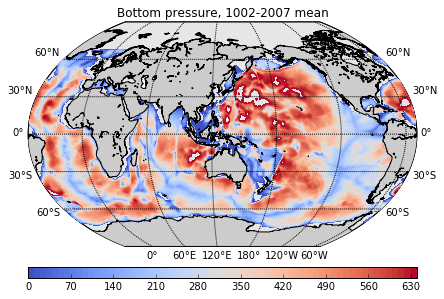

In [19]:
makeFig(pBot_mean, 0,650,10, 'Bottom pressure, 1002-2007 mean', plt.cm.coolwarm,'bottomPressureTimeMean.png')

In [26]:
pBot_mean.shape

(360, 270)

In [11]:
b_prMattF=io.loadmat('/home/maike/Documents/BPT/BPT_calc/time_mean_pressbot.mat')
b_prMatt=b_prMattF['botpress_mean']
lat_cMatt=b_prMattF['lat_c']
lon_cMatt=b_prMattF['lon_c']

In [96]:
ecco_paramsF=io.loadmat('/home/maike/Documents/BPT/BPT_calc/ecco_params.mat')
time_mean_pressF=io.loadmat('/home/maike/Documents/BPT/BPT_calc/time_mean_press.mat')
depth_l=ecco_paramsF['depth_l']

In [93]:
time_mean_pressF.keys()
ecco_paramsF.keys()

['depth_l',
 'lon_u',
 'depth_c',
 'lat_c',
 '__header__',
 '__globals__',
 'lon_c',
 'lat_v',
 '__version__']

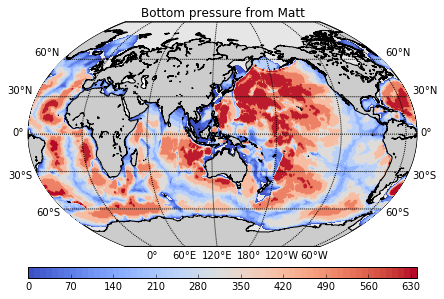

In [21]:
data=b_prMatt; cMin=0; cMax=650; cStep=10; title='Bottom pressure from Matt'; ColMap=plt.cm.coolwarm; saveName='bprMatt.png'
plt.figure(figsize=(20,12))
dataPlot=data
#cMin, cMax, cStep = 0,0.008, 0.0001
dataIn = data
lons = np.roll(np.linspace(0, 360, 360),100)
lons = lon_cMatt
dataIn,lons = shiftgrid(lon_cMatt[0],np.flipud(dataIn),lons,start=True, cyclic=360)
lats = lat_cMatt
llons, llats = np.meshgrid(lons,lats)
fig = plt.figure()
ax = fig.add_axes([0.05,0.05,0.9,0.9])
# create Basemap instance.
m = Basemap(projection='kav7',lon_0=130,resolution='l')
m.drawmapboundary(fill_color='0.9')
im1 = m.contourf(llons,llats,np.fliplr(np.fliplr(dataPlot)),np.arange(cMin, cMax, cStep),shading='flat',cmap=ColMap,latlon=True)
m.drawmapboundary(fill_color='0.9')
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1])
m.drawcoastlines()
m.fillcontinents()
cb = m.colorbar(im1,"bottom", size="5%", pad="9%")
# add a title.
ax.set_title(title)
plt.savefig(saveName, format='png', dpi=500)
plt.show()

In [29]:
print(b_prMatt.shape, pBot_mean.shape, lon_collated.shape, lat_collated.shape)

lon = lon_collated[:,1];lat = lat_collated[1,:] #NB! FIX! This grid is not regular

(160, 360) (360, 270) (360, 270) (360, 270)


In [89]:
# establish some standard values
lon_diff=1.111774765625000e+05
Omega=7.2921e-5 #2*np.pi/T

f=np.array(2*Omega*np.sin((np.arange(np.min(lat),np.max(lat),abs(lat[2]-lat[1])))*np.pi/180)) # coriolis parameter at cell centre

beta_fgrid=np.zeros(lat.shape);beta_fgrid[:]=np.nan  
beta_fgrid[2:270]=((f[2:270]-f[1:270-1])/(lon_diff)) # Gives beta at the cell corner (the vorticity point)
beta_fgrid=beta_fgrid.repeat(360).reshape(360,270)   # Just makes it 2D


In [110]:
f =Dataset('/home/maike/Documents/ECCO4_rel2/'+'nctiles_grid'+'/'+'GRID'+'.00{:02d}.nc'.format(3))
depthRC = f.variables['RC']
depth_l = f.variables['RF']  # Probably the ones for the f points? Who knows!?! (OK, JMC knows.. and Gael too)

In [ ]:
# grid cell widths and heights etc. 
grid_width_u=(lon_diff*np.cos(lat*np.pi/180))*np.ones(360)
grid_width_v=(lon_diff.*np.cos(lat*np.pi/180))*np.ones(360)
depth_l_diff=np.append(10,np.diff(np.abs(depth_l)))
depth_l_diff_glob=np.rollaxis(np.tile(depth_l_diff,(270,360,50)),2,0)
grid_width_u_glob=permute(repmat(grid_width_u,[1 1 length(depth_l)]),[3 1 2])
grid_width_v_glob=permute(repmat(grid_width_v,[1 1 length(depth_l)]),[3 1 2])

In [ ]:
np.title(depth_l_diff, (270,360))

In [145]:
depth_l_diff_glob=np.rollaxis(np.tile(depth_l_diff,(270,360,50)),2,0)
depth_l_diff_glob[:,150,150]

array([  10. ,   10. ,   10. , ...,  387.5,  410.5,  433.5])

In [141]:
aa = np.rollaxis(np.tile([2,3,4],(5,5,1)),2,0)

In [144]:
depth_l_diff=np.append(10,np.diff(np.abs(depth_l)))

In [148]:
f =Dataset('/home/maike/Documents/ECCO4_rel2/'+'nctiles_grid'+'/'+'GRID'+'.00{:02d}.nc'.format(3))
drf = f.variables['DRF']
drc = f.variables['DRC']

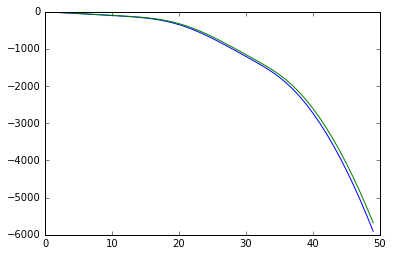

In [108]:
plt.plot(depthRC)
plt.plot(depthRF)

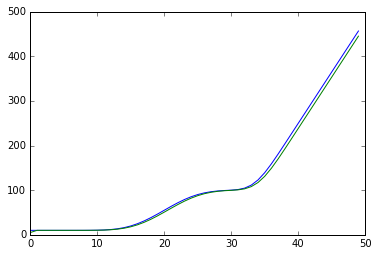

In [149]:
plt.plot(drf)
plt.plot(drc)

In [88]:
cc.shape

(360, 270)